# PyTorch Inception and DenseNet



# Preprocessing


In [1]:
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 2.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
##### Could clean this up a bit

%matplotlib inline

import os
import time
import copy
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import cv2

import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.io import read_image
from torchvision import datasets, models
from torchvision.utils import make_grid
from torchvision.utils import save_image
from torch.utils import data
from torchsummary import summary
#import torchmetrics
#from torchmetrics.classification import BinaryAUROC

from pathlib import Path
from pydicom import dcmread
from tqdm.notebook import tqdm
import skimage.io as sk

from PIL import Image

#torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 2.1.0+cu121


In [4]:
##### Specify Device

device = torch.device("cpu")

if torch.cuda.is_available():
   print("Training on GPU")
   device = torch.device("cuda:0")


Training on GPU


#Data Preparation

In [5]:
#Make Labels
df = pd.read_csv("/content/drive/MyDrive/Saliency Map Research 2023/Pneumothorax Dataset/Pneumothorax_Labels_Final.csv")
df = df.rename(columns={"label": "Target", "ImageId": "patientId"})
df2 = df[['Split','patientId','Target']]

df_train = df2.loc[(df2['Split'] == 'train')]
df_train = df_train.drop(df_train.columns[[0]], axis=1)
df_train = df_train.reset_index(drop=True)

df_val = df2.loc[(df2['Split'] == 'val')]
df_val = df_val.drop(df_val.columns[[0]], axis=1)
df_val = df_val.reset_index(drop=True)

df_test = df2.loc[(df2['Split'] == 'test')]
df_test = df_test.drop(df_test.columns[[0]], axis=1)
df_test = df_test.reset_index(drop=True)

#Reduce Size for testing
#train_total = 200
#val_total = 100
#test_total = 0

#df_train = df_train[:train_total]
#df_val = df_val[:val_total]
#df_test = df_test[:test_total]

#Path Split
root = '/content/drive/MyDrive/Saliency Map Research 2023/Pneumothorax Dataset/images_png/PNG/train'

train_labels = df_train[['patientId', 'Target']].to_numpy()
val_labels = df_val[['patientId', 'Target']].to_numpy()
test_labels = df_test[['patientId', 'Target']].to_numpy()

train_paths = [os.path.join(root, image[0]) for image in train_labels]
val_paths = [os.path.join(root, image[0]) for image in val_labels]
test_paths = [os.path.join(root, image[0]) for image in test_labels]

In [6]:
print(f'patientId: {train_labels[0][0]}, Target: {train_labels[0][1]}')
print(len(train_paths))
print(len(test_paths))
df.shape[0]

patientId: 1.2.276.0.7230010.3.1.4.8323329.10287.1517875222.997107, Target: 1
8636
1064


10661

# Transformation & Dataloader


In [7]:
##### Transformations
transform_v3 = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(299)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_dense = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224)),
    #torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

##### Custom Dataset

class Dataset(data.Dataset):

    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(f'{self.paths[index]}.png').convert("RGB")
        #image = image.pixel_array
        #image = image / 255.0

        #image = (255*image).clip(0, 255).astype(np.uint8)
        #image = Image.fromarray(image).convert('RGB')

        label = self.labels[index][1]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):

        return len(self.paths)

class PneumothoraxDataset(Dataset):
    def __init__(self, root_dir, annotation_file, transform=None):
        self.root_dir = root_dir
        self.annotations = annotation_file
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_id = (self.annotations.iloc[index, 0] + '.png')
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")
        y_label = torch.tensor(float(self.annotations.iloc[index, 1]))

        if self.transform is not None:
            img = self.transform(img)

        return (img, y_label)

In [8]:
##### Dataloader ONLY TRAIN AND VAL RIGHT NOW

batch_sz = 4

##### INCEPTION
train_dataset_v3 = PneumothoraxDataset(root, df_train, transform=transform_v3)
val_dataset_v3 = PneumothoraxDataset(root, df_val,transform=transform_v3)
train_loader_v3 = torch.utils.data.DataLoader(dataset=train_dataset_v3, batch_size=batch_sz, shuffle=True)
val_loader_v3 = torch.utils.data.DataLoader(dataset=val_dataset_v3, batch_size=batch_sz, shuffle=False)

print('Number of training batches', len(train_loader_v3))
print('Number of validation batches', len(val_loader_v3))

##### DENSE
train_dataset_dense = PneumothoraxDataset(root, df_train, transform=transform_dense)
val_dataset_dense = PneumothoraxDataset(root, df_val, transform=transform_dense)
train_loader_dense = torch.utils.data.DataLoader(dataset=train_dataset_dense, batch_size=batch_sz, shuffle=True)
val_loader_dense = torch.utils.data.DataLoader(dataset=val_dataset_dense, batch_size=batch_sz, shuffle=False)

##### SEPERATING INTO DICTIONARIES FOR EASE OF USE
dataloaders_dict_v3 = {'train': train_loader_v3, 'val': val_loader_v3}
dataloaders_dict_dense = {'train': train_loader_dense, 'val': val_loader_dense}

Number of training batches 2159
Number of validation batches 241


# Data Visualization

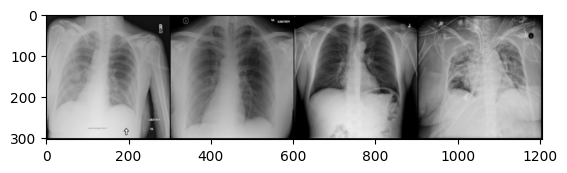

In [9]:
batch = iter(train_loader_v3)
images, labels = next(batch)

image_grid = torchvision.utils.make_grid(images[:4])
image_np = image_grid.numpy()
img = np.transpose(image_np, (1, 2, 0))
plt.imshow(img)

#Model Definition

with lr_scheduler

In [10]:
import time
import copy
import torch
from torch.optim import lr_scheduler

def train_model(model, model_name, dataloaders, criterion, optimizer, num_epochs=20, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epochs_without_improvement = 0
    early_stopping_epochs = 5


    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                labels = labels.type(torch.LongTensor)
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4 * loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val':
                val_acc_history.append(epoch_acc)

                if epoch_acc > best_acc:
                    epochs_without_improvement = 0
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    if model_name == "inception":
                        checkpoint_inception = model
                        save_checkpoint(checkpoint_inception, "/content/drive/MyDrive/Saliency Map Research 2023/Models/thorax_inception.pt")
                    elif model_name == "densenet":
                        checkpoint_dense = model
                        save_checkpoint(checkpoint_dense, "/content/drive/MyDrive/Saliency Map Research 2023/Models/thorax_dense.pt")
                    elif model_name == "resnet":
                        checkpoint_dense = model
                        save_checkpoint(checkpoint_dense, "/content/drive/MyDrive/Saliency Map Research 2023/Models/thorax_resnet.pt")
                else:
                    epochs_without_improvement += 1

                if epochs_without_improvement >= early_stopping_epochs:
                    print('Early stopping triggered. No improvement in validation accuracy for {} epochs.'.format(early_stopping_epochs))
                    time_elapsed = time.time() - since
                    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
                    print('Best val Acc: {:4f}'.format(best_acc))

                    # Load best model weights
                    model.load_state_dict(best_model_wts)
                    return model, val_acc_history


        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

##### CHECKPOINT STORAGE
def save_checkpoint(state, filename):
  print("=======> SAVING CHECKPOINT")
  torch.save(state, filename)

###### FEATURE EXTRACT
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

##### INITIALIZE
def initialize_model(model_name, num_classes,feature_extract):
  model_ft = None
  input_size = 0

  if model_name == "densenet":
      model_ft = models.densenet121(pretrained=True)
      set_parameter_requires_grad(model_ft, feature_extract)
      num_ftrs = model_ft.classifier.in_features
      model_ft.classifier = nn.Linear(1024, num_classes)
      ##### NUM CLASSES ON LAST FC MIGHT NEED FIXING
      input_size = 224

  elif model_name == "inception":
      """ Inception v3
      Be careful, expects (299,299) sized images and has auxiliary output
      """
      model_ft = models.inception_v3(pretrained=True)
      set_parameter_requires_grad(model_ft, feature_extract)
      num_ftrs = model_ft.AuxLogits.fc.in_features
      model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
      ##### NUM CLASSES ON LAST FC MIGHT NEED FIXING
      num_ftrs = model_ft.fc.in_features
      model_ft.fc = nn.Linear(num_ftrs,num_classes)
      ##### NUM CLASSES ON LAST FC MIGHT NEED FIXING
      input_size = 299

  elif model_name == "resnet":
      """ Resnet101
      """
      model_ft = models.resnet101(pretrained=True)
      set_parameter_requires_grad(model_ft, feature_extract)
      num_ftrs = model_ft.fc.in_features
      model_ft.fc = nn.Linear(num_ftrs, num_classes)
      input_size = 224

  else:
      print("Invalid model name, exiting...")
      exit()

  return model_ft, input_size

In [ ]:
##### Code from pytorch finetuning torchvision models tutorial
##### From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958

##### CHECKPOINT STORAGE
def save_checkpoint(state, filename):
  print("=======> SAVING CHECKPOINT")
  torch.save(state, filename)

###### FEATURE EXTRACT
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

##### TRAIN FUNCTION
def train_model(model, model_name, dataloaders, criterion, optimizer, num_epochs=20, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                labels = labels.type(torch.LongTensor) ####DIFFERENT
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)


                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            #epoch_auc = metric(outputs, labels)
            #print(outputs, labels)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            ##### SAVE MODEL AND CALC BEST STATS
            if phase == 'val' and epoch_acc > best_acc:
                if model_name == "inception":
                  checkpoint_inception = model
                  #save_checkpoint(checkpoint_inception, "/content/drive/MyDrive/Saliency Map Research 2023/Models/thorax_inception.pt")
                  save_checkpoint(checkpoint_inception, "/content/drive/MyDrive/Saliency Map Research 2023/Repeatability/new model/new_thorax_inception.pt")
                elif model_name == "densenet":
                  checkpoint_dense = model
                  save_checkpoint(checkpoint_dense, "/content/drive/MyDrive/Saliency Map Research 2023/Models/thorax_dense.pt")
                elif model_name == "resnet":
                  checkpoint_dense = model
                  save_checkpoint(checkpoint_dense, "/content/drive/MyDrive/Saliency Map Research 2023/Models/thorax_resnet.pt")
                best_acc = epoch_acc
                #best_auc = epoch_auc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

            ##### Break Statements for Early Stopping
            #if phase == 'val' and model_name == "inception" and best_auc > inception_early_stopping:
            #  break
            #elif phase == 'val' and model_name == "densenet" and best_auc > densenet_early_stopping:
            #  break

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

##### INITIALIZE
def initialize_model(model_name, num_classes,feature_extract):
  model_ft = None
  input_size = 0

  if model_name == "densenet":
      model_ft = models.densenet121(pretrained=True)
      set_parameter_requires_grad(model_ft, feature_extract)
      num_ftrs = model_ft.classifier.in_features
      model_ft.classifier = nn.Linear(1024, num_classes)
      ##### NUM CLASSES ON LAST FC MIGHT NEED FIXING
      input_size = 224

  elif model_name == "inception":
      """ Inception v3
      Be careful, expects (299,299) sized images and has auxiliary output
      """
      model_ft = models.inception_v3(pretrained=True)
      set_parameter_requires_grad(model_ft, feature_extract)
      num_ftrs = model_ft.AuxLogits.fc.in_features
      model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
      ##### NUM CLASSES ON LAST FC MIGHT NEED FIXING
      num_ftrs = model_ft.fc.in_features
      model_ft.fc = nn.Linear(num_ftrs,num_classes)
      ##### NUM CLASSES ON LAST FC MIGHT NEED FIXING
      input_size = 299

  elif model_name == "resnet":
      """ Resnet101
      """
      model_ft = models.resnet101(pretrained=True)
      set_parameter_requires_grad(model_ft, feature_extract)
      num_ftrs = model_ft.fc.in_features
      model_ft.fc = nn.Linear(num_ftrs, num_classes)
      input_size = 224

  else:
      print("Invalid model name, exiting...")
      exit()

  return model_ft, input_size

# Inception V3 Model

In [11]:
##### INPUTS
num_classes = 2
num_epochs_v3 = 20
model_name_v3 = "resnet"
m = nn.Sigmoid()
#criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()
feature_extract = False

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [12]:
model_ft, input_size = initialize_model(model_name_v3, num_classes, feature_extract)
#print(model_ft)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 193MB/s]


In [13]:
###### UPDATING MODEL PARAMETERS, GET SUMMARY

model_ft = model_ft.to(device)
params_to_update = model_ft.parameters()

print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

optimizer_ft_v3 = optim.SGD(params_to_update, lr=0.00007, momentum=0.9)
#optimizer_ft_v3 = optim.Adam(params_to_update, lr=1e-4)

#summary(model_ft, (3, 299, 299))

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight

In [14]:
model_ft, hist = train_model(model_ft, model_name_v3, dataloaders_dict_v3, criterion, optimizer_ft_v3, num_epochs=num_epochs_v3, is_inception=(model_name_v3=="inception"))

Epoch 0/19
----------
train Loss: 0.4646 Acc: 0.7855
val Loss: 0.4109 Acc: 0.8293
=======> SAVING CHECKPOINT

Epoch 1/19
----------
train Loss: 0.3971 Acc: 0.8198
val Loss: 0.3349 Acc: 0.8408
=======> SAVING CHECKPOINT

Epoch 2/19
----------
train Loss: 0.3719 Acc: 0.8366
val Loss: 0.3370 Acc: 0.8460
=======> SAVING CHECKPOINT

Epoch 3/19
----------
train Loss: 0.3493 Acc: 0.8495
val Loss: 0.3432 Acc: 0.8429

Epoch 4/19
----------
train Loss: 0.3208 Acc: 0.8683
val Loss: 0.3209 Acc: 0.8574
=======> SAVING CHECKPOINT

Epoch 5/19
----------
train Loss: 0.2942 Acc: 0.8820
val Loss: 0.3325 Acc: 0.8408

Epoch 6/19
----------
train Loss: 0.2703 Acc: 0.8921
val Loss: 0.3083 Acc: 0.8637
=======> SAVING CHECKPOINT

Epoch 7/19
----------
train Loss: 0.2305 Acc: 0.9132
val Loss: 0.3556 Acc: 0.8470

Epoch 8/19
----------
train Loss: 0.1975 Acc: 0.9253
val Loss: 0.3879 Acc: 0.8512

Epoch 9/19
----------
train Loss: 0.1954 Acc: 0.9243
val Loss: 0.3415 Acc: 0.8710
=======> SAVING CHECKPOINT

Epoch 10

In [ ]:
torch.save(model_ft, '/content/drive/MyDrive/Saliency Map Research 2023/Repeatability/new model/new_thorax_inception2.pt')

#Dense-Net 121

In [ ]:
##### DENSE NET 121 MODEL #####

##### DENSE NET NEXT
##### POTENTIALLY MOVE TO NEW NOTEBOOK

#dense = models.densenet121(pretrained=True)
model_name_dense = "densenet"
#criterion = nn.BCEWithLogitsLoss()
num_epochs_dense = 30

In [ ]:
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name_dense, num_classes, feature_extract)

In [ ]:
###### UPDATING MODEL PARAMETERS, GET SUMMARY

model_ft = model_ft.to(device)
params_to_update = model_ft.parameters()

print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

optimizer_ft_dense = optim.SGD(params_to_update, lr=7e-5, momentum=0.9)

#summary(model_ft, (3, 299, 299))

Params to learn:
	 features.conv0.weight
	 features.norm0.weight
	 features.norm0.bias
	 features.denseblock1.denselayer1.norm1.weight
	 features.denseblock1.denselayer1.norm1.bias
	 features.denseblock1.denselayer1.conv1.weight
	 features.denseblock1.denselayer1.norm2.weight
	 features.denseblock1.denselayer1.norm2.bias
	 features.denseblock1.denselayer1.conv2.weight
	 features.denseblock1.denselayer2.norm1.weight
	 features.denseblock1.denselayer2.norm1.bias
	 features.denseblock1.denselayer2.conv1.weight
	 features.denseblock1.denselayer2.norm2.weight
	 features.denseblock1.denselayer2.norm2.bias
	 features.denseblock1.denselayer2.conv2.weight
	 features.denseblock1.denselayer3.norm1.weight
	 features.denseblock1.denselayer3.norm1.bias
	 features.denseblock1.denselayer3.conv1.weight
	 features.denseblock1.denselayer3.norm2.weight
	 features.denseblock1.denselayer3.norm2.bias
	 features.denseblock1.denselayer3.conv2.weight
	 features.denseblock1.denselayer4.norm1.weight
	 features.de

In [ ]:
# Train and evaluate
model_ft, hist = train_model(model_ft, model_name_dense, dataloaders_dict_dense, criterion, optimizer_ft_dense, num_epochs=num_epochs_dense, is_inception=False)

Epoch 0/29
----------
train Loss: 0.4729 Acc: 0.7844
val Loss: 0.3945 Acc: 0.8241
=======> SAVING CHECKPOINT

Epoch 1/29
----------
train Loss: 0.4121 Acc: 0.8154
val Loss: 0.3507 Acc: 0.8429
=======> SAVING CHECKPOINT

Epoch 2/29
----------
train Loss: 0.3782 Acc: 0.8314
val Loss: 0.3318 Acc: 0.8408

Epoch 3/29
----------
train Loss: 0.3507 Acc: 0.8475
val Loss: 0.3320 Acc: 0.8377

Epoch 4/29
----------
train Loss: 0.3154 Acc: 0.8672
val Loss: 0.3437 Acc: 0.8439
=======> SAVING CHECKPOINT

Epoch 5/29
----------
train Loss: 0.2888 Acc: 0.8827
val Loss: 0.3944 Acc: 0.8200

Epoch 6/29
----------
train Loss: 0.2568 Acc: 0.8979
val Loss: 0.3450 Acc: 0.8470
=======> SAVING CHECKPOINT

Epoch 7/29
----------
train Loss: 0.2249 Acc: 0.9140
val Loss: 0.3807 Acc: 0.8460

Epoch 8/29
----------
train Loss: 0.1960 Acc: 0.9250
val Loss: 0.3989 Acc: 0.8450

Epoch 9/29
----------
train Loss: 0.1731 Acc: 0.9371
val Loss: 0.3965 Acc: 0.8366

Epoch 10/29
----------
train Loss: 0.1577 Acc: 0.9449
val Loss

#Test

In [ ]:
batch_sz = 4

val_dataset_v3 = PneumothoraxDataset(root, df_val, transform=transform_v3)
val_loader_v3 = torch.utils.data.DataLoader(dataset=val_dataset_v3, batch_size=batch_sz, shuffle=False)
test_dataset_v3 = PneumothoraxDataset(root, df_test, transform=transform_v3)
test_loader_v3 = torch.utils.data.DataLoader(dataset=test_dataset_v3, batch_size=batch_sz, shuffle=True)

val_dataset_dense = PneumothoraxDataset(root, df_val, transform=transform_dense)
val_loader_dense = torch.utils.data.DataLoader(dataset=val_dataset_dense, batch_size=batch_sz, shuffle=False)
test_dataset_dense = PneumothoraxDataset(root, df_test, transform=transform_dense)
test_loader_dense = torch.utils.data.DataLoader(dataset=test_dataset_dense, batch_size=batch_sz, shuffle=True)

In [ ]:
from sklearn import metrics
from tqdm import tqdm
import torch.nn.functional as nnf

In [ ]:
from torch.autograd import Variable

model = model_ft

model.eval()
prob1 = []
results = []
final_targets = []
#names = []
print('===============================================start')
for num, data in enumerate(test_loader_dense):
     #print(num)
     #print("=====================================================")

     imgs, label = data
     imgs,labels = imgs.to(device), label.to(device)
     test = Variable(imgs)
     output = model(test)
     #print(output)
     ps = torch.exp(output)
     prob = nnf.softmax(output, dim=1)
     prob1 += prob.detach().cpu().numpy().tolist()
     #print(prob1[:1])
     top_p, top_class = prob.topk(1, dim = 1)
     results += top_class.cpu().numpy().tolist()

     targets = labels.detach().cpu().numpy().tolist()
     final_targets.extend(targets)

print('===============================================end')

===============================================start
===============================================end


In [ ]:
print(prob1)
prob2 = []
for x in prob1:
  prob2.append(x[1])

print(prob2)

#print(final_targets)
#results = [item for sublist in results for item in sublist]
#print(results)
roc_auc = metrics.roc_auc_score(final_targets, results)
print(roc_auc)

[[0.9999996423721313, 3.1963304536475334e-07], [0.9999904632568359, 9.530601346341427e-06], [0.9982153177261353, 0.0017847057897597551], [0.9330815076828003, 0.06691848486661911], [0.44357919692993164, 0.5564208030700684], [0.9999940395355225, 5.9832268561876845e-06], [0.9999932050704956, 6.742756795574678e-06], [0.9946637153625488, 0.005336255766451359], [0.9329598546028137, 0.06704006344079971], [0.9919812679290771, 0.008018719032406807], [0.004941508173942566, 0.995058536529541], [0.059107184410095215, 0.9408928155899048], [0.9997362494468689, 0.0002637573634274304], [0.9478486180305481, 0.05215135216712952], [0.9999556541442871, 4.4337823055684566e-05], [0.9834048748016357, 0.01659507490694523], [0.9745427966117859, 0.025457270443439484], [1.0, 1.4456376096205759e-09], [0.9213031530380249, 0.07869681715965271], [0.427110880613327, 0.5728891491889954], [0.9999998807907104, 1.1282723733074818e-07], [1.0, 7.220674613783729e-10], [0.16875340044498444, 0.831246554851532], [0.03737800195

In [ ]:
roc_auc = metrics.roc_auc_score(final_targets, prob2)
print(roc_auc)

0.8822954822954823


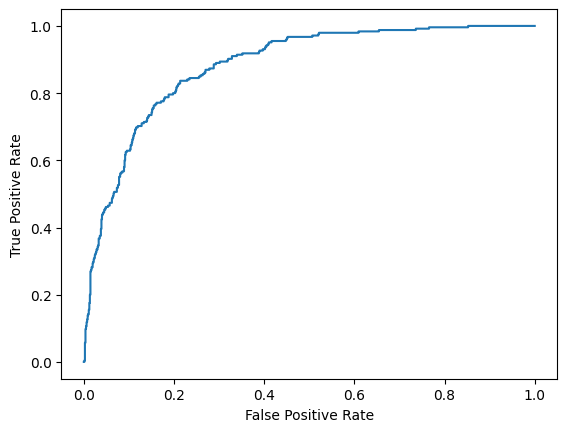

In [ ]:
fpr, tpr, thresh = metrics.roc_curve(final_targets,  prob2, drop_intermediate=False)
#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#ResNet101


In [ ]:
##### ResNet 101 MODEL #####

##### Used for object detection
#####

resnet = models.resnet101(pretrained=True)
model_name_resnet = "resnet"
#criterion = nn.BCEWithLogitsLoss()
num_epochs_resnet = 20

In [ ]:
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name_resnet, num_classes, feature_extract)

In [ ]:
# Send the model to GPU
model_ft = model_ft.to(device)
params_to_update = model_ft.parameters()
optimizer_ft_resnet = optim.Adam(params_to_update, lr=1e-4)

#summary(model_ft, (3, 224, 224))

In [ ]:
# Train and evaluate
model_ft, hist = train_model(model_ft, model_name_resnet, dataloaders_dict_dense, criterion, optimizer_ft_resnet, num_epochs=num_epochs_resnet, is_inception=False)


#LOAD MODELS

In [ ]:
inception_load = torch.load('/content/drive/MyDrive/Pneumonia Dataset/Inception_Model/inception.pt')
print(inception_load.keys())

def load_checkpoint(checkpoint):
  model_ft.load_state_dict(checkpoint['state_dict'])

inception = load_checkpoint(torch.load("/content/drive/MyDrive/Pneumonia Dataset/Inception_Model/inception.pt"))